<a href="https://colab.research.google.com/github/yiyinglai/Pneumonia/blob/master/ipynb/Overall_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# %tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from keras.utils import plot_model
import matplotlib.pyplot as plt
from scipy import interp
import numpy as np
import tqdm
import math
import os
import cv2
! pip install git+https://github.com/divamgupta/image-segmentation-keras.git

Using TensorFlow backend.


  Cloning https://github.com/divamgupta/image-segmentation-keras.git to /tmp/pip-req-build-360zp12_
  Running command git clone -q https://github.com/divamgupta/image-segmentation-keras.git /tmp/pip-req-build-360zp12_
     |████████████████████████████████| 28.3MB 1.4MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp36-none-any.whl size=39858 sha256=d1c302dfd73bce9d0559199ac06e2c7158da7403fa1635e09a177afec0c9e8ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7ufkdi1/wheels/0a/4e/8b/d3f9088958a351a72f48ede4558836b78a03c0c124f81f41ed
Successfully built keras-segmentation
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28


In [0]:
!pip uninstall matplotlib && pip install matplotlib==2.0.2

Uninstalling matplotlib-2.2.2:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/matplotlib-2.2.2-py3.6-nspkg.pth
    /usr/local/lib/python3.6/dist-packages/matplotlib-2.2.2.dist-info/*
    /usr/local/lib/python3.6/dist-packages/matplotlib/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.6/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.6/dist-packages/pylab.py
Proceed (y/n)? n
     |████████████████████████████████| 14.6MB 5.1MB/s 
ERROR: plotnine 0.5.1 has requirement matplotlib>=3.0.0, but you'll have matplotlib 2.0.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 2.2.2
    Unin

**Model1**

In [0]:
from keras.models import load_model
model1 = load_model('/content/gdrive/My Drive/ECE1512/stage1/model1/model1_17epochs.h5')
for layer in model1.layers:
  layer.trainable = False

**Lungseg**

In [0]:
# LOAD lungseg
from keras_segmentation.models.pspnet import pspnet_101

# re-create a fresh new pspnet_101 model and load weights
lungseg = pspnet_101(n_classes=2, input_height=473, input_width=473)
lungseg.load_weights('/content/gdrive/My Drive/ECE1512/MontgomerySet/lungseg/lungseg_weights.hdf5.0')


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Model2**

In [0]:
from keras.models import load_model

model2 = load_model('/content/gdrive/My Drive/ECE1512/model2_2.h5')

**Overall: initialize pd dataframe**


In [0]:
import pandas as pd
import os

test_files = os.listdir('/content/gdrive/My Drive/ECE1512/combined_test_set')
df = pd.DataFrame(index=test_files)
# normal 0, bacteria 1, virus 2
df['true_label'] = [2 if 'virus' in name else 1 if 'bacteria' in name else 0 for name in df.index]
df['stage1_label'] = ''
df['stage1_prob'] = ''
df['stage2_label'] = ''
df['stage2_prob'] = ''
df['pred_label'] = ''
df['conf_score'] = ''

**Overall: stage1**

In [0]:
import cv2
import tqdm

pbar = tqdm.tqdm(total=len(test_files))
for file in test_files:
  pbar.update(1)
  idx = df.index.get_loc(file)
  image = cv2.imread(os.path.join('/content/gdrive/My Drive/ECE1512/combined_test_set', file))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (299, 299))/255.
  stage1_probs = model1.predict(np.array([image,]))
  stage1_label = np.argmax(stage1_probs)
  stage1_prob = stage1_probs[0][stage1_label]
  df['stage1_label'][idx] = stage1_label
  df['stage1_prob'][idx] = stage1_prob
pbar.close()

**Overall: stage2**

In [0]:
pbar = tqdm.tqdm(total=len(test_files))
for file in test_files:
  pbar.update(1)
  idx = df.index.get_loc(file)
  if df['stage1_label'][idx] == 1:
    x = cv2.resize(cv2.imread(os.path.join('/content/gdrive/My Drive/ECE1512/combined_test_set', file)), (473, 473))
    y = lungseg.predict_segmentation(x)
    segmented = np.copy(x)
    segmented[y == 0] = 0
    segmented = cv2.resize(segmented, (299, 299))/255.
    stage2_probs = model2.predict(np.array([segmented,]))
    stage2_label = np.argmax(stage2_probs)
    stage2_prob = stage2_probs[0][stage2_label]
    df['stage2_label'][idx] = stage2_label
    df['stage2_prob'][idx] = stage2_prob
pbar.close()

In [0]:
pbar = tqdm.tqdm(total=len(test_files))
for file in test_files:
  pbar.update(1)
  idx = df.index.get_loc(file)
  if df['stage1_label'][idx] == 0:
    df['pred_label'][idx] = 0
    df['conf_score'][idx] = df['stage1_prob'][idx]
  else:
    df['pred_label'][idx] = df['stage2_label'][idx] + 1
    df['conf_score'][idx] = df['stage2_prob'][idx]
pbar.close()

**Overall: visualize results**

In [0]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df[['true_label', 'pred_label', 'conf_score']])

                                true_label pred_label conf_score
person389_virus_778.jpeg                 2          2   0.691809
person387_bacteria_1769.jpeg             1          1   0.585739
person374_bacteria_1711.jpeg             1          1   0.939602
person378_virus_761.jpeg                 2          2   0.691985
person373_bacteria_1709.jpeg             1          1   0.984154
person379_bacteria_1721.jpeg             1          1   0.575046
person382_bacteria_1740.jpeg             1          1   0.935589
person37_bacteria_186.jpeg               1          1   0.923028
person371_bacteria_1695.jpeg             1          1   0.670909
person371_bacteria_1702.jpeg             1          1   0.960676
person373_bacteria_1708.jpeg             1          0   0.710079
person370_bacteria_1689.jpeg             1          1   0.706122
person379_bacteria_1722.jpeg             1          1   0.830426
person370_bacteria_1688.jpeg             1          1   0.983597
person370_bacteria_1687.j

**Overall: confusion matrix**

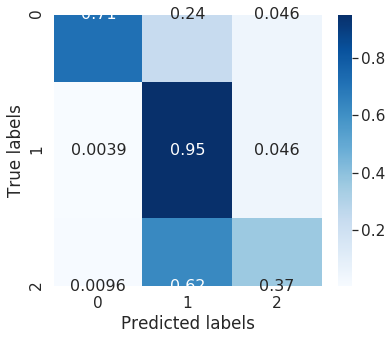

In [0]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

y_true = df['true_label'].to_list()
cm = confusion_matrix(df['true_label'].to_list(), df['pred_label'].to_list())
norm_cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(norm_cm, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'True labels'
df_cm.columns.name = 'Predicted labels'
plt.figure(figsize = (6, 5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [0]:
# cropped plot because of matplotlib version, confusion matrix is saved on PC
df_cm.to_pickle('/content/gdrive/My Drive/ECE1512/confusion_matrix.pkl')

**Overall: receiver operating characteristic**

In [0]:
true_labels = []
pred_labels = []

for file in test_files:
  idx =  df.index.get_loc(file)
  temp = [0, 0, 0]
  temp[df['true_label'][idx]] = 1
  true_labels.append(temp)
  temp2 = [0, 0, 0]
  temp2[df['pred_label'][idx]] = 1
  pred_labels.append(temp2)
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

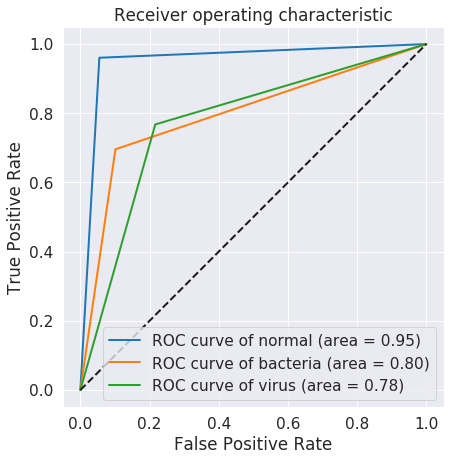

In [0]:
# Compute ROC curve and ROC area for each class    

classes = ['normal', 'bacteria', 'virus']

defect_fpr = dict()
defect_tpr = dict()
defect_roc_auc = dict()

for i in range(3):
  defect_fpr[i], defect_tpr[i], _ = roc_curve(pred_labels[:, i], true_labels[:, i])

for i in range(3):
  defect_roc_auc[i] = auc(defect_fpr[i], defect_tpr[i])

# Plot all ROC curves
fig = plt.figure(figsize=(7, 7))
lw = 2
colors = ['tab:blue', 'tab:orange', 'tab:green']
for i, color in zip(range(3), colors):
    plt.plot(defect_fpr[i], defect_tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(classes[i], defect_roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('/content/gdrive/My Drive/ECE1512/ROC.png')